In [1]:
import os
import sys

In [2]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt

In [4]:
import ase
from ase.io import cube
from ase.io import cif
import h5py
import pickle
import io
import json
import re

In [3]:


from IPython.display import display, HTML
from scipy.spatial import Delaunay
import plotly
from plotly.graph_objs import graph_objs as go
import ipywidgets as widgets
plotly.offline.init_notebook_mode(connected=True)
from plotly.offline import iplot

In [5]:
import pymatgen.core as mg
from pymatgen.io.cif import CifWriter
from pymatgen.io.cif import CifFile
from pymatgen.core.structure import Structure

In [6]:
import gudhi,gudhi.hera,gudhi.wasserstein,persim
import ripserplusplus as rpp

In [38]:
class PDhash():
    def __init__(self,res=1,diags=None, maxHdim=2,persistThresh=0):
        """upper bound resolution.
        In the case of sparce PD spaces, it may be useful to project a hash map of your dataset to the diagram space"""
        self.res=res
        self.maxD=maxHdim
        self.thresh=persistThresh
        self.bounds=[[np.inf,-np.inf] for b in range(maxHdim+1)]
        self.img={b:dict() for b in range(maxHdim+1)} # While this does impose extra time compared to np, it is ideal for map-reduce type parallelization




    def addDiagRpp(self,diag,index): ## note the index can be just an index number, or a numerical value
                                    ###although the numerical values (duplicate index) won't stack in the set
        """diag is {0:[(b,d),...],1: """
        for i in range(np.min([self.maxD+1,len(diag)])):
            for k in diag[i]:
                if k[1]-k[0] >self.thresh:
                    pt=(round(k[0]/self.res)*self.res,round(k[1]/self.res)*self.res)
                    if pt[0]<self.bounds[i][0]:
                        self.bounds[i][0]=pt[0]
                    if pt[1]>self.bounds[i][1]:
                        self.bounds[i][1]=pt[1]
                    if pt in self.img[i]:
                        if index in self.img[i][pt]:
                            self.img[i][pt][index]+=1
                        else:
                            self.img[i][pt][index]=1

                    else:
                        self.img[i][pt]={index:1}

    def addDiagCubeRips(self,crispy,index):
        """diag is [[bi,b,d,bx,by,bz,dx,dy,dz],..] """
        pass

    def __getitem__(self, item):
        if type(item)==int: #item is bi
            return self.img[item]
        else:
            #return {b:self.img[b][pt] for b in range(self.maxD) for pt in self.img[b].keys()}
            return {b:self.img[b][tuple(item)] for b in range(self.maxD) if tuple(item) in self.img[b]}

    #def indexImgMap(self,fn=lambda pt: np.sum([v*k for k,v in self.img])): #assuming index is something numerically useful like a property assocated to each PD

    def mean_to_numpy(self,bi=None):
        roundDig=8
        if type(bi)==int and bi<=self.maxD:
            mi,ma=self.bounds[bi]
            life=int((self.bounds[bi][1]-self.bounds[bi][0])/self.res + 1)
            meanBox=np.zeros((life,life),dtype='float32')

            for k,v in self.img[bi].items():
                if type(v)==dict:
                    meanBox[int((ma-k[1])/self.res),int((k[0]-mi)/self.res)]=np.round(np.sum([t*p for p,t in v.items()])/np.sum([t for p,t in v.items()]),roundDig)
                else:
                    meanBox[int((ma-k[1])/self.res),int((k[0]-mi)/self.res)]=np.round(np.mean(list(v)),roundDig)
            return meanBox



def boxStatsIndex(pdStack):
    return {b:{pt:(np.mean(np.array(list(pdStack[b][pt]),dtype=np.float32)),np.var(np.array(list(pdStack[b][pt]),dtype=np.float32))) for pt in pdStack[b].keys()} for b in pdStack.img.keys()}

def mean_to_numpy(pdStack,bi=None):
    roundDig=8
    if type(bi)==int and bi<=pdStack.maxD:
        mi,ma=pdStack.bounds[bi]
        life=int((pdStack.bounds[bi][1]-pdStack.bounds[bi][0])/pdStack.res + 1)
        meanBox=np.zeros((life,life),dtype='float32')

        for k,v in pdStack.img[bi].items():
            if type(v)==dict:
                meanBox[int((ma-k[1])/pdStack.res),int((k[0]-mi)/pdStack.res)]=np.round(np.sum([t*p for p,t in v.items()])/np.sum([t for p,t in v.items()]),roundDig)
            else:
                meanBox[int((ma-k[1])/pdStack.res),int((k[0]-mi)/pdStack.res)]=np.round(np.mean(list(v)),roundDig)
        return meanBox



In [7]:
inDir="Z:/data/diverse_metals"
os.chdir(inDir)
hDir="Z:/data/hMOF"
hdf=pd.read_csv(f"{hDir}/id_prop.csv",index_col=0,header=None)
hdf.columns=["workCap"]

(array([6.742e+03, 1.282e+03, 2.782e+03, 4.025e+03, 6.379e+03, 8.409e+03,
        9.238e+03, 9.172e+03, 8.635e+03, 8.352e+03, 8.195e+03, 7.910e+03,
        7.204e+03, 6.834e+03, 6.308e+03, 5.866e+03, 5.072e+03, 4.572e+03,
        3.976e+03, 3.359e+03, 2.832e+03, 2.505e+03, 1.946e+03, 1.557e+03,
        1.210e+03, 9.110e+02, 7.320e+02, 5.480e+02, 4.060e+02, 2.710e+02,
        1.550e+02, 1.060e+02, 7.600e+01, 4.600e+01, 2.200e+01, 5.000e+00,
        6.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

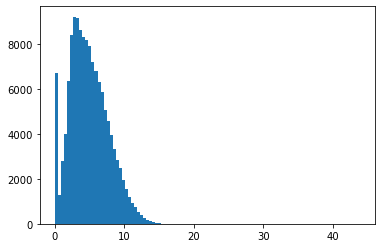

In [8]:
plt.hist(hdf["workCap"],bins=100)

(array([1.959e+03, 1.578e+03, 1.299e+03, 1.116e+03, 8.690e+02, 7.360e+02,
        6.020e+02, 5.090e+02, 3.530e+02, 3.100e+02, 2.170e+02, 1.510e+02,
        7.600e+01, 8.000e+01, 6.100e+01, 3.600e+01, 2.100e+01, 1.300e+01,
        3.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

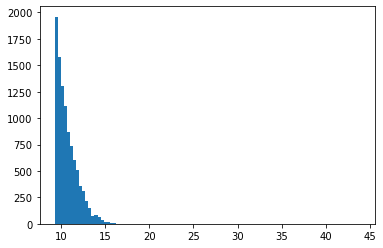

In [20]:
plt.hist(df.sort_values(by="workCap").iloc[-10000:],bins=100)

In [9]:
fName="hMOF-69.cif"
struct=Structure.from_file(f"{inDir}/hMOF-1039C2-CO2/{fName}")

# Stratified Samps

In [9]:
trP=.7

numBins=5
regVars=["workCap"]
bounds={k:[(0,np.quantile(hdf[k],1/numBins))] for k in regVars}

k="workCap"
for j in range(numBins-2):
    bounds[k].append((bounds[k][j][1],np.quantile(hdf[k],(j+2)/numBins)))
bounds[k].append((bounds[k][-1][1],))
bounds

{'workCap': [(0, 2.527062),
  (2.527062, 3.862188),
  (3.862188, 5.342439999999999),
  (5.342439999999999, 7.242992),
  (7.242992,)]}

In [10]:
df=hdf

totalLen=len(df["workCap"])
trP=.70
np.random.seed(42)


indexBounds={k:[] for k in bounds.keys()} #upper index for

for k in regVars:
    j=0
    bj=0
    for index,row in df.sort_values(by=[k]).iterrows():
        if bj>=len(bounds[k])-1:
            break
        elif row[k]>bounds[k][bj][1]:
            indexBounds[k].append(j)
            bj+=1
        j+=1

        

testBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[:indexBounds[k][j]],size=round((1-trP)*indexBounds[k][j]),replace=False)))
    for j in range(1,len(indexBounds[k])):
        testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]],size=round((1-trP)*(indexBounds[k][j]-indexBounds[k][j-1])),replace=False)))
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][-1]:],size=round((1-trP)*(totalLen-indexBounds[k][-1])),replace=False)))



trainBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[:indexBounds[k][j]])-set(testBins[k][j])))
    for j in range(1,len(indexBounds[k])):
        trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]])-set(testBins[k][j])))
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][-1]:])-set(testBins[k][-1])))



In [36]:
len(trainBins["workCap"][-1])

19272

In [19]:
len(hdf['workCap'])

137652

In [21]:
fName=testBins["workCap"][-1][-1]

In [22]:
struct=Structure.from_file(f"{inDir}/hMOF-1039C2-CO2/{fName}")

In [31]:
fName=list(trainBins["workCap"][-1])[-2]

# PDHash gen

In [32]:
hinDir="Z:/data/diverse_metals/hMOF-1039C2-CO2"

fName
struct=Structure.from_file(f"{hinDir}/{fName}",frac_tolerance=1e-8)
rppdgm=rpp.run("--format distance --dim 2",struct.distance_matrix)

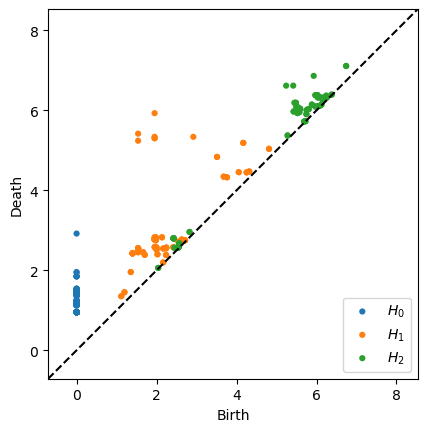

In [30]:
npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
persim.plot_diagrams(npdgm)

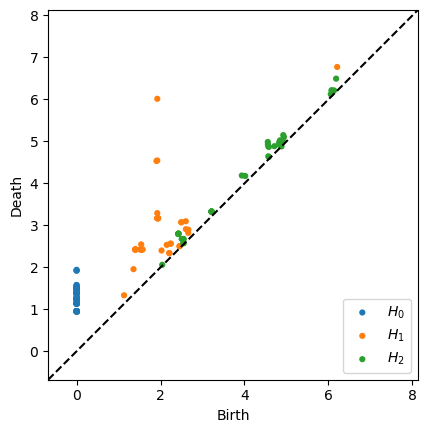

In [33]:
npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
persim.plot_diagrams(npdgm)

In [50]:
struct=Structure.from_file(cif_name,{frac_tolerance=1e-8})

SyntaxError: invalid syntax (1042423275.py, line 1)

# This is a header

In [51]:
binNum=0

hinDir="Z:/data/diverse_metals/hMOF-1039C2-CO2"
hOut="Z:/data/diverse_metals/hMOF_PDhash"
hIndex=list(trainBins["workCap"][binNum])

pdStack=PDhash(res=.25,diags=None, maxHdim=2,persistThresh=0)
failMOFs=set()

for i in range(len(hIndex)):
    fName=hIndex[i]
    cif_name=f"{hinDir}/{fName}"
    try:
        struct=Structure.from_file(cif_name,)
        rppdgm=rpp.run("--format distance --dim 2",struct.distance_matrix)
        npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
        pdStack.addDiagRpp(npdgm,i)
    except:
        failMOFs.add(fName)


with open(f"{hOut}/train_pdStack_b{binNum}_5.pkl","wb") as f:
    pickle.dump(pdStack,f)

C:\Users\moore\anaconda3\lib\site-packages\pymatgen\io\cif.py:1167: UserWarning:

Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.



In [53]:
binNum=1

hinDir="Z:/data/diverse_metals/hMOF-1039C2-CO2"
hOut="Z:/data/diverse_metals/hMOF_PDhash"


pdStack=PDhash(res=.25,diags=None, maxHdim=2,persistThresh=0)
failMOFs=set()
for binNum in range(1,4):
    hIndex=list(trainBins["workCap"][binNum])
    for i in range(len(hIndex)):
        fName=hIndex[i]
        cif_name=f"{hinDir}/{fName}"
        try:
            struct=Structure.from_file(cif_name,)
            rppdgm=rpp.run("--format distance --dim 2",struct.distance_matrix)
            npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
            pdStack.addDiagRpp(npdgm,i)
        except:
            failMOFs.add(fName)
    with open(f"{hOut}/train_pdStack_b{binNum}_5.pkl","wb") as f:
        pickle.dump(pdStack,f)




C:\Users\moore\anaconda3\lib\site-packages\pymatgen\io\cif.py:1167: UserWarning:

Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.



In [52]:
for i in range(5):
    with open(f"{hOut}/train_pdStack_index_b{i}_5.pkl","wb") as f:
        pickle.dump(list(trainBins["workCap"][i]),f)

In [44]:
def boxProjectSet(pdStack,df,regVar,indexMap=None):### set project vs freq project
    pdProj=PDhash(res=pdStack.res,diags=None,maxHdim=pdStack.maxD,persistThresh=pdStack.thresh)
    pdProj.bounds=pdStack.bounds
    if indexMap:
        pdProj.img={b:{pt:{df.loc[indexMap[i]][regVar] for i in pdStack.img[b][pt]} for pt in pdStack.img[b].keys()} for b in pdStack.img.keys()}
    else:
        pdProj.img={b:{pt:{df.iloc[i][regVar] for i in pdStack.img[b][pt]} for pt in pdStack.img[b].keys()} for b in pdStack.img.keys()}
    return pdProj




In [41]:
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.offline as pyo
import numpy as np

In [42]:
b=0



X=mean_to_numpy(pdStack,bi=b)
x=np.linspace(pdStack.bounds[b][0],pdStack.bounds[b][1],len(X))

y=x
trace=go.Heatmap(x=x, y=y, z=X[::-1], colorscale='Viridis')
layout = go.Layout(title=f"B{b} XYZ_Persistence Map - Colored by workingCap")
fig = go.Figure(data=[trace], layout=layout)

saveDir="C:/code/git/topML/frames/hMOF"

pyo.plot(fig, filename=f"{saveDir}/{b}XYZ_workCap_bin{binNum}.html")
fig.write_image(f"{saveDir}/{b}XYZ_workCap.png")


fig.show()